# GradCAM Visualization for Trained Model

This notebook loads the trained DenseNet-121 model and visualizes GradCAM activations on test images.

In [10]:
# Import Required Libraries
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from tqdm import tqdm

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as F

import sys
sys.path.append('..')
from experiments.squeeze_excitation_experiment import create_model_for_experiment

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Load the Trained Model

Load the model from the checkpoint file.

In [3]:
# Load model checkpoint
checkpoint_path = '../trained_models/Definitive model/best_test_accuracy.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model instance with SE blocks (same architecture as training)
model = create_model_for_experiment("Sweep", num_classes=8)

# Load weights
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model loaded from {checkpoint_path}")
print(f"Training epoch: {checkpoint['epoch']}")
print(f"Device: {device}")

Model loaded from ../trained_models/Definitive model/best_test_accuracy.pt
Training epoch: 40
Device: cpu


/tmp/ipykernel_2883129/4053867985.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


## Load Test Dataset and Evaluate Accuracy

In [4]:
# Prepare test data
IMG_SIZE = 224
test_transformation = F.Compose([
    F.ToImage(),
    F.ToDtype(torch.float32, scale=True),
    F.Resize(size=(IMG_SIZE, IMG_SIZE)),
])

test_folder = os.path.expanduser('/ghome/mcv/datasets/C3/2425/MIT_small_train_1/test')
data_test = ImageFolder(test_folder, transform=test_transformation)
test_loader = DataLoader(data_test, batch_size=32, shuffle=False, num_workers=4)

print(f"Test dataset loaded: {len(data_test)} images")
print(f"Classes: {data_test.classes}")

Test dataset loaded: 2288 images
Classes: ['Opencountry', 'coast', 'forest', 'highway', 'inside_city', 'mountain', 'street', 'tallbuilding']


In [5]:
model.eval()  # set model to evaluation mode
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():  # no gradient computation
    for images, labels in test_loader:
        images = images.to(device)  # move to GPU if needed
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # get predicted class
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())  # move to CPU and store
        all_labels.append(labels.cpu())

# Convert lists to a single tensor/array
all_preds = torch.cat(all_preds)
all_probs = torch.cat(all_probs, dim=0).numpy()
all_labels = torch.cat(all_labels)

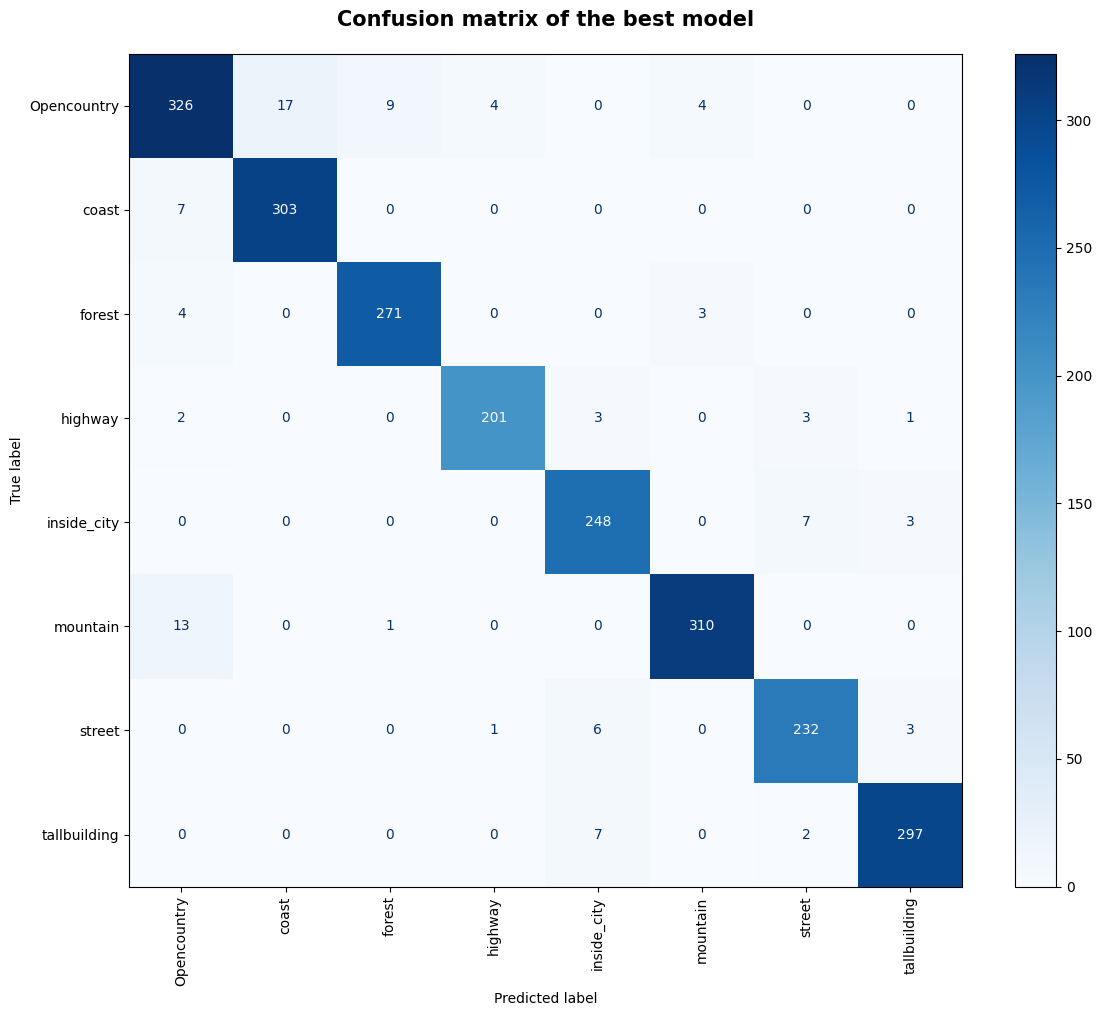

In [13]:
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_test.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, ax=plt.gca())  # optional: choose color map
plt.title("Confusion matrix of the best model", fontsize=15, pad=20, fontweight='bold')
plt.tight_layout()
plt.show()

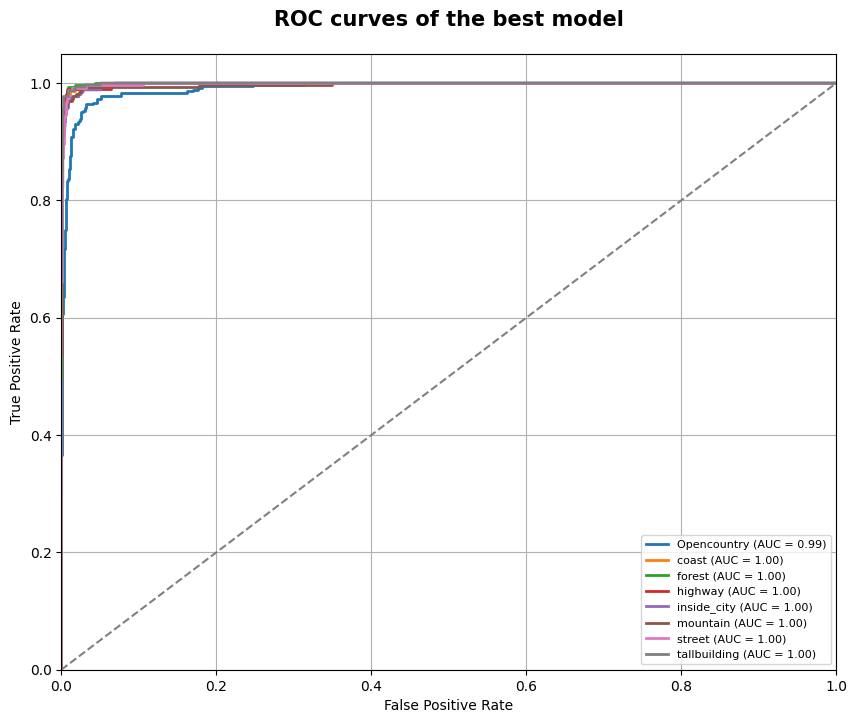

In [12]:
n_classes = len(data_test.classes)
y_true = np.array(label_binarize(all_labels, classes=np.arange(n_classes)))
# y_true.shape = (num_samples, n_classes)
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{data_test.classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curves of the best model", fontsize=15, pad=20, fontweight='bold')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.show()